# Faster Fourier Transfom
This notebook show how the FFT1.5D method can be use to speed computation in online cartesian MRI reconstruction.


In [1]:
%matplotlib notebook
DATA_DIR = "data/"
N_JOBS = 1
import numpy as np
import matplotlib.pyplot as plt
import tikzplotlib as pltikz
from utils import implot, load_data
from mri.operators import FFT
from online.operators import ColumnFFT

/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/pac/gits/phd/pysap-mri/mri/operators/fourier/non_cartesian.py:42: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "


(16, 640, 320) complex128
(320, 320) float32
file_brain_AXFLAIR_200_6002462.h5
1


<IPython.core.display.Javascript object>


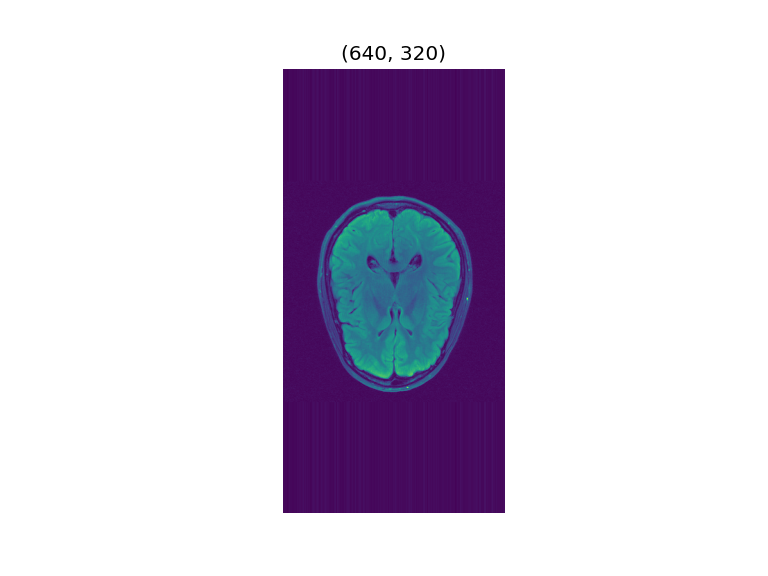

In [3]:
kspace, real_img, mask_loc, final_mask = load_data(DATA_DIR,1)
real_img =real_img.astype(complex)
implot(real_img,title=str(real_img.shape))
K_DIM = kspace.shape[-2:]
N_COILS = 1
line_mask = np.zeros_like(final_mask)
line_mask[:,K_DIM[1]//2] = 1

# Precision 
## Forward operator

<ipython-input-4-0d4fb7a3d7f1>:21: RuntimeWarning: invalid value encountered in true_divide
  peak_rel_err_phase[k] =100* max(abs(np.angle(res15d)-np.angle(res2d))/np.angle(res2d))


<IPython.core.display.Javascript object>


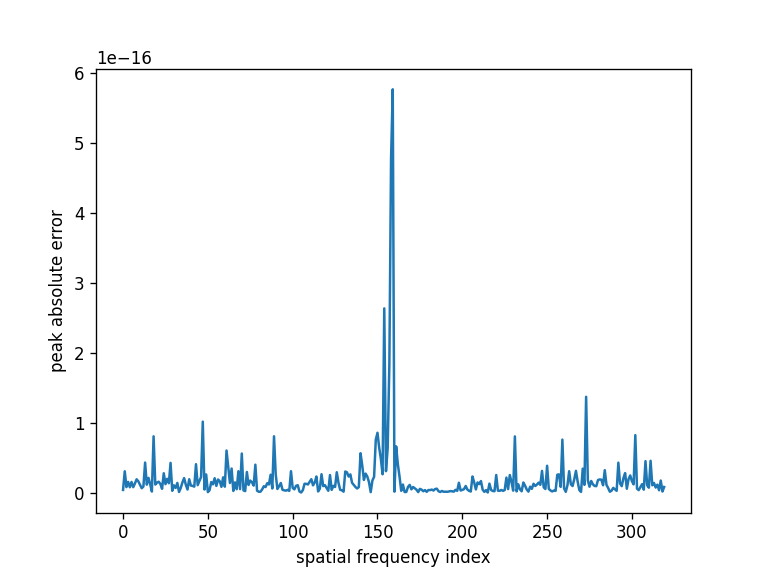

<IPython.core.display.Javascript object>


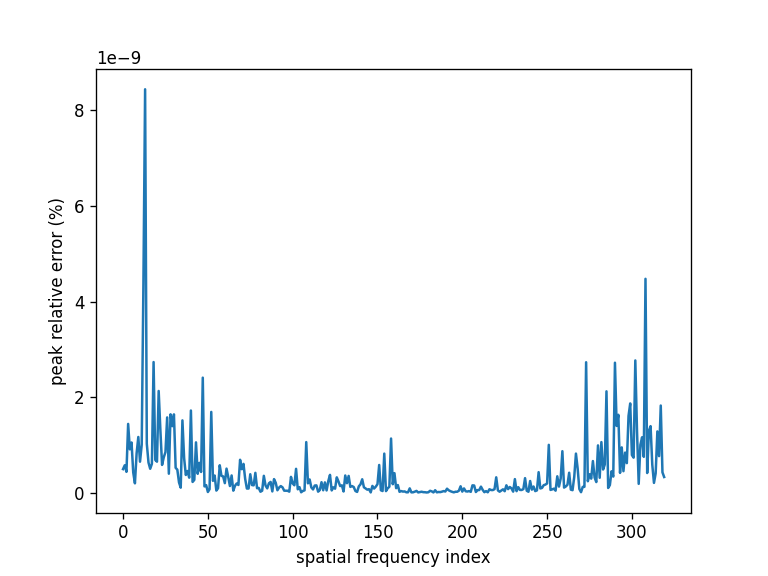

<IPython.core.display.Javascript object>


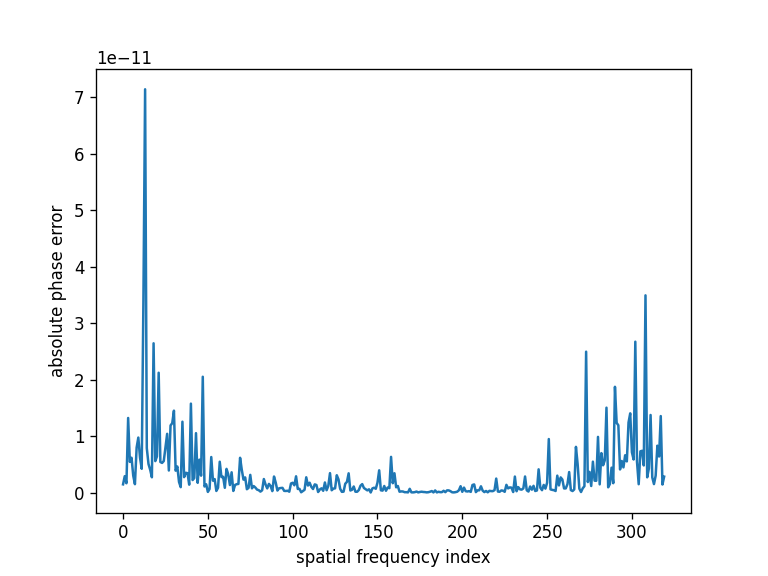

<IPython.core.display.Javascript object>


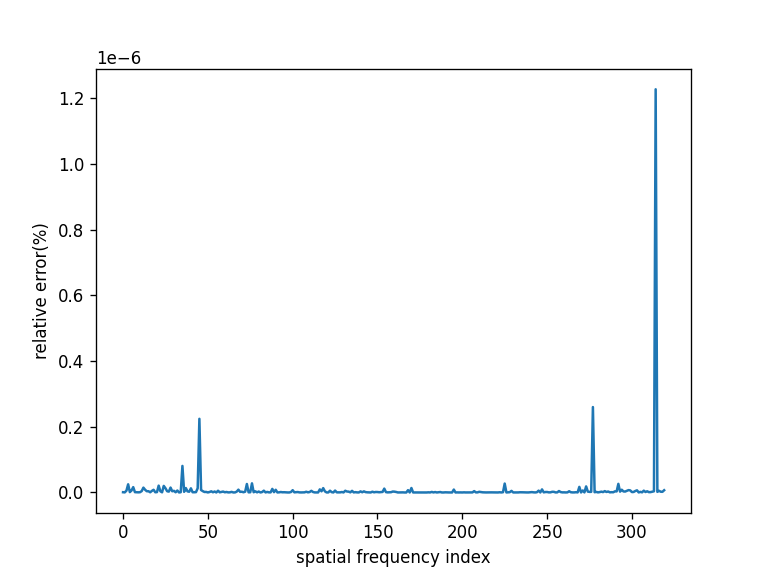

Text(0, 0.5, 'relative error(%)')

In [4]:

fft2d = FFT(shape=K_DIM,n_coils=N_COILS,mask=line_mask)
fft15d = ColumnFFT(shape=K_DIM, n_coils=N_COILS,line_index=K_DIM[1]//2, platform='numba')

peak_err = np.zeros(real_img.shape[1])
peak_rel_err = np.zeros(real_img.shape[1])
peak_err_phase = np.zeros(real_img.shape[1])
peak_rel_err_phase = np.zeros(real_img.shape[1])

for k in range(real_img.shape[1]):
    line_mask = np.zeros_like(final_mask)
    line_mask[:,k] = 1
    fft2d.mask = line_mask
    fft15d.line_index = k
    res2d = fft2d.op(real_img)[:,k]
    res15d = fft15d.op(real_img)
    err = res2d - res15d
    peak_err[k] = max(abs(err))
    peak_rel_err[k] = 100*max(abs(err)/abs(res2d))

    peak_err_phase[k] = max(abs(np.angle(res15d)-np.angle(res2d)))
    peak_rel_err_phase[k] =100* max(abs(np.angle(res15d)-np.angle(res2d))/np.angle(res2d))

    
plt.figure()
plt.plot(peak_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak absolute error')

plt.figure()
plt.plot(peak_rel_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak relative error (%)')
pltikz.save('diff_fft_op_rel.tikz')
    
plt.figure()
plt.plot(peak_err_phase)
plt.xlabel('spatial frequency index')
plt.ylabel('absolute phase error')
    
plt.figure()
plt.plot(peak_rel_err_phase)
plt.xlabel('spatial frequency index')
plt.ylabel('relative error(%)')

## Adjoint Operator

<IPython.core.display.Javascript object>


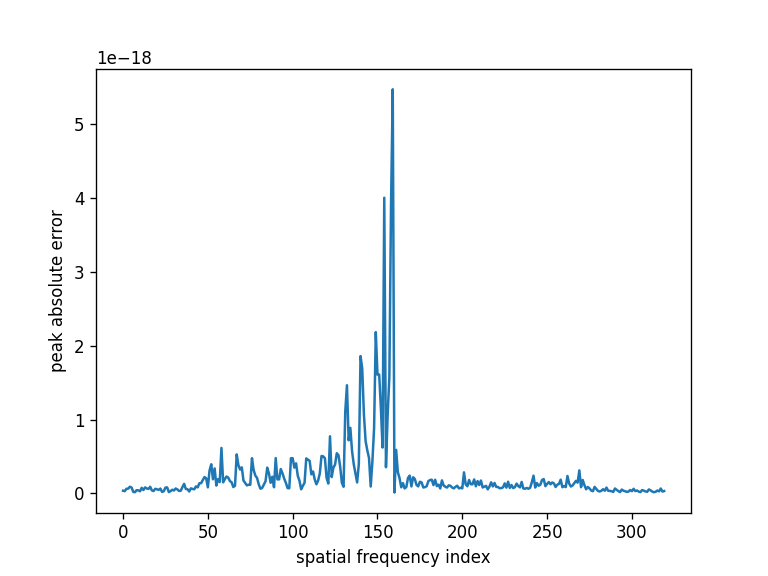

<IPython.core.display.Javascript object>


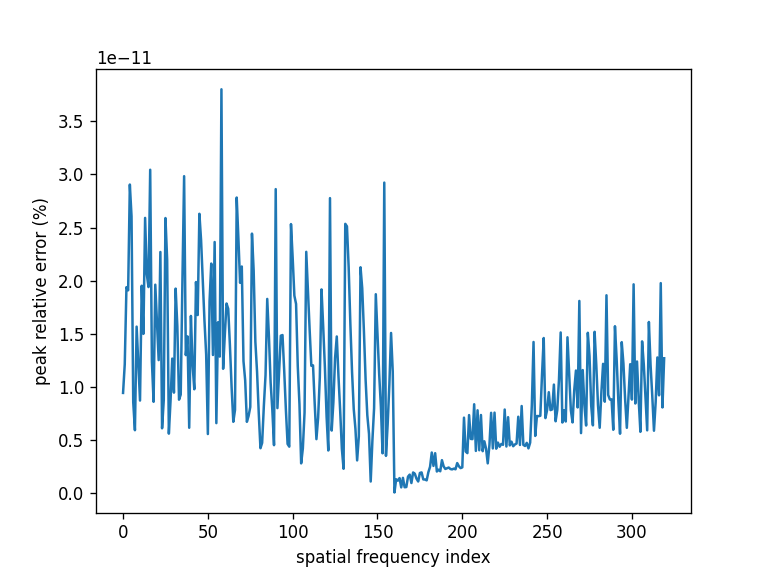

In [5]:

fft2d = FFT(shape=K_DIM,n_coils=N_COILS,mask=line_mask)
fft15d = ColumnFFT(shape=K_DIM, n_coils=N_COILS,line_index=K_DIM[1]//2, platform='numpy')

kspace = FFT(shape=K_DIM,n_coils=N_COILS,mask=np.ones(real_img.shape)).op(real_img)

peak_err = np.zeros(real_img.shape[1])
peak_rel_err = np.zeros(real_img.shape[1])
peak_err_phase = np.zeros(real_img.shape[1])
peak_rel_err_phase = np.zeros(real_img.shape[1])

for k in range(real_img.shape[1]):
    line_kspace = kspace[:,k]
    kspace_line = np.zeros_like(kspace)
    kspace_line[:,k] = kspace[:,k]
    line_mask = np.zeros_like(final_mask)
    line_mask[:,k] = 1
    fft2d.mask = line_mask
    fft15d.line_index = k 
    res2d = fft2d.adj_op(kspace_line).flatten()
    res15d = fft15d.adj_op(line_kspace).flatten()
    err = res2d - res15d
    peak_err[k] = max(abs(err))
    peak_rel_err[k] = 100*max(abs(err)/abs(res2d))

    peak_err_phase[k] = max(abs(np.angle(res15d)-np.angle(res2d)))
    peak_rel_err_phase[k] =100* max(abs(np.angle(res15d)-np.angle(res2d))/np.angle(res2d))

    
plt.figure()
plt.plot(peak_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak absolute error')

plt.figure()
plt.plot(peak_rel_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak relative error (%)')
pltikz.save('diff_fft_adjop_rel.tikz')

## Auto-adjoint operation

<IPython.core.display.Javascript object>


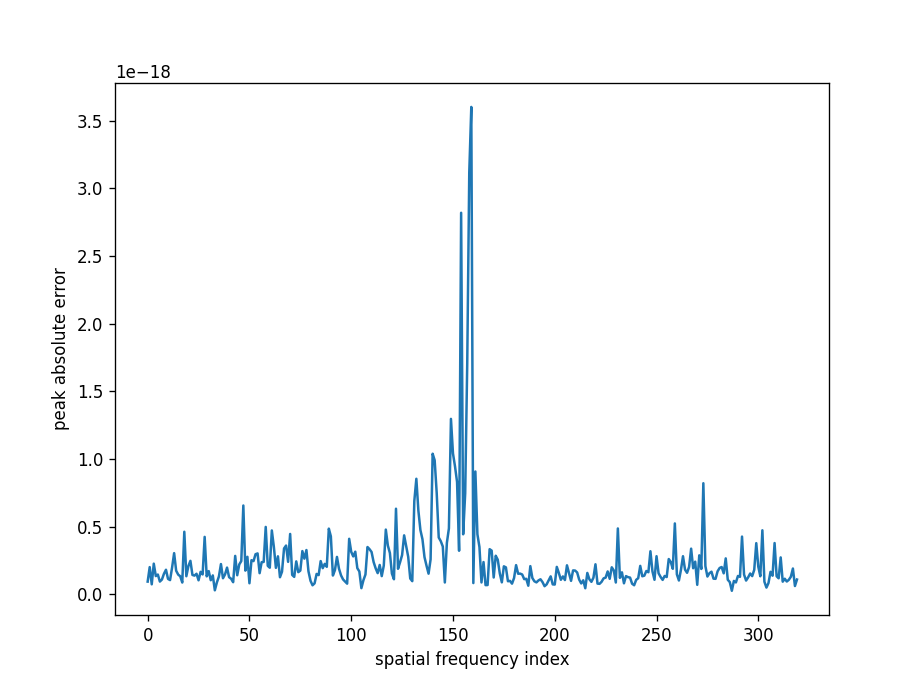

<IPython.core.display.Javascript object>


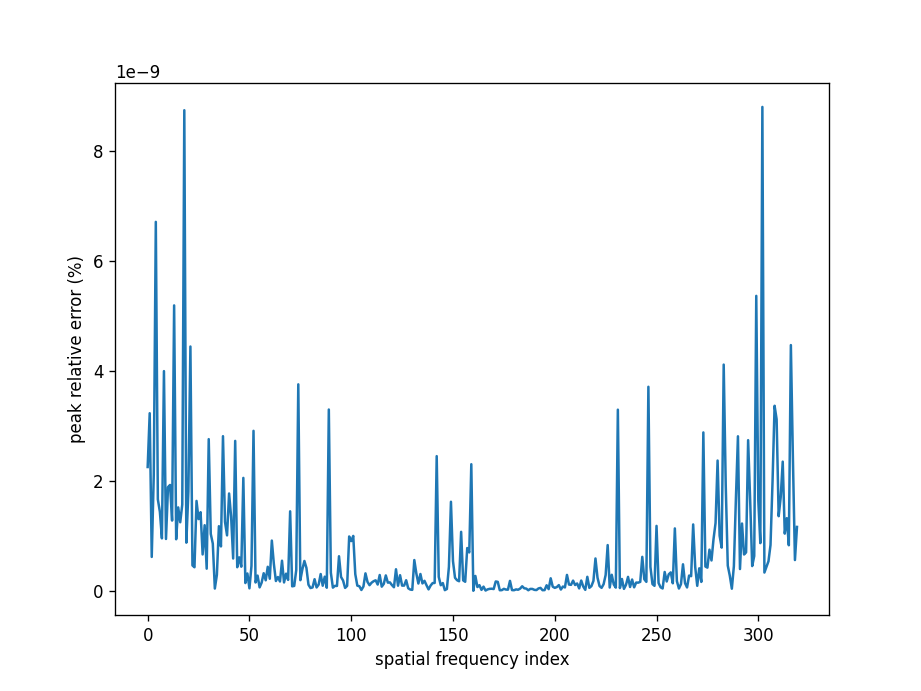

In [8]:

fft2d = FFT(shape=K_DIM,n_coils=N_COILS,mask=line_mask)
fft15d = ColumnFFT(shape=K_DIM, n_coils=N_COILS,line_index=K_DIM[1]//2, platform='numpy')

peak_err = np.zeros(real_img.shape[1])
peak_rel_err = np.zeros(real_img.shape[1])
peak_err_phase = np.zeros(real_img.shape[1])
peak_rel_err_phase = np.zeros(real_img.shape[1])

for k in range(real_img.shape[1]):
    line_kspace = kspace[:,k]
    line_mask = np.zeros_like(final_mask)
    line_mask[:,k] = 1
    fft2d.mask = line_mask
    fft15d.line_index = k 
    res2d = fft2d.adj_op(fft2d.op(real_img)).flatten()
    res15d = fft15d.adj_op(fft15d.op(real_img)).flatten()
    err = res2d - res15d
    peak_err[k] = max(abs(err))
    peak_rel_err[k] = 100*max(abs(err)/abs(res2d))

    peak_err_phase[k] = max(abs(np.angle(res15d)-np.angle(res2d)))
    peak_rel_err_phase[k] =100* max(abs(np.angle(res15d)-np.angle(res2d))/np.angle(res2d))

    
plt.figure()
plt.plot(peak_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak absolute error')

plt.figure()
plt.plot(peak_rel_err)
plt.xlabel('spatial frequency index')
plt.ylabel('peak relative error (%)')
pltikz.save('diff_fft_auto_op_rel.tikz')

# Time 

In [9]:
from timeit import timeit

size = 32*np.array([2,4,6,8,10,12,14,16, 20, 24, 32])
coils = np.array([1,2,4,8,16])
t= np.zeros((len(coils), len(size), 4))


for n, n_coils in enumerate(coils):
    for i,s in enumerate(size):
        fft2d = FFT(shape=(s,s),n_coils=n_coils,mask=np.ones(s))
        fft15np = ColumnFFT(shape=(s,s), n_coils=n_coils,line_index=s//2, platform='numpy')
        fft15nb = ColumnFFT(shape=(s,s), n_coils=n_coils,line_index=s//2, platform='numba_multi')
        fft15gu = ColumnFFT(shape=(s,s), n_coils=n_coils,line_index=s//2, platform='gufunc')
        fake_data = np.random.random((n_coils, s,s)).astype(complex)
        for f, fft in enumerate([fft2d, fft15np, fft15nb, fft15gu]):
            t[n,i,f] = timeit(lambda: fft.op(fake_data),number=20)

<IPython.core.display.Javascript object>


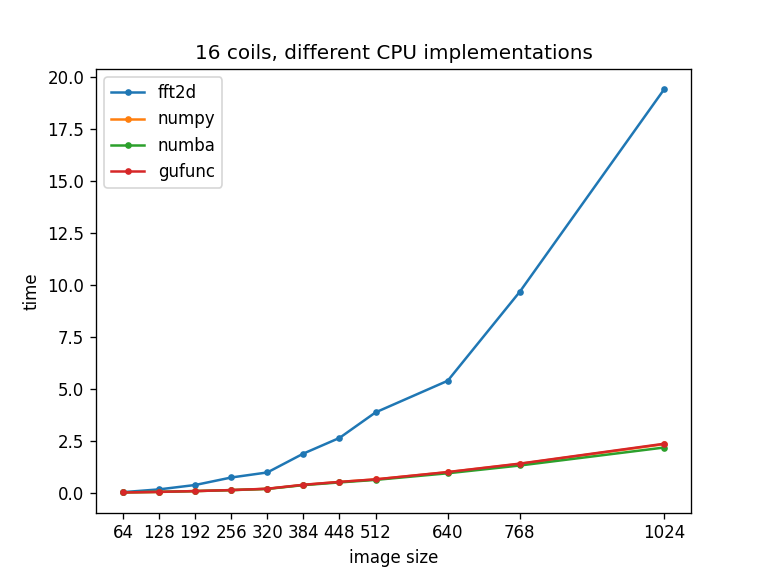

<IPython.core.display.Javascript object>


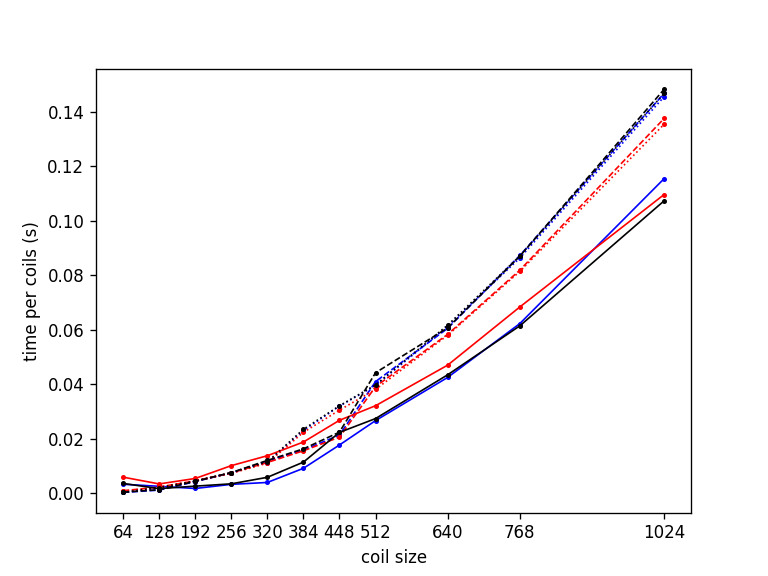

In [12]:
plt.figure()
legend = ('fft2d','numpy','numba','gufunc')

for f, leg in enumerate(legend):
        plt.plot(size,t[4,:, f], '.-',label=leg)
plt.xticks(size)
plt.legend()
plt.title('16 coils, different CPU implementations')
plt.xlabel('image size')
plt.ylabel('time')
pltikz.save('fft_comp_16.tikz')
gt = t[:,:,1:]
plt.figure()
plt.xticks(size)
plt.plot(size,gt[0,:,0]/1,'.-b',linewidth=1,markersize=4)
plt.plot(size,gt[3,:,0]/8,'.--b',linewidth=1,markersize=4)
plt.plot(size,gt[4,:,0]/16,'.--b',linewidth=1,markersize=4)
plt.plot(size,gt[0,:,1]/1,'.-r',linewidth=1,markersize=4)
plt.plot(size,gt[3,:,1]/8,'.--r',linewidth=1,markersize=4)
plt.plot(size,gt[4,:,1]/16,'.--r',linewidth=1,markersize=4)
plt.plot(size,gt[0,:,2]/1,'.-k',linewidth=1,markersize=4)
plt.plot(size,gt[3,:,2]/8,'.--k',linewidth=1,markersize=4)
plt.plot(size,gt[4,:,2]/16,'.:k',linewidth=1,markersize=4)
plt.xlabel('coil size')
plt.ylabel('time per coils (s)')
pltikz.save('fft_comp_multi.tikz')


# Conclusion
The use of a tailored operator, 